# 04 - Full waveform inversion with Dask and Devito pickling

## Introduction

Here, we revisit [04_dask.ipynb: Full Waveform Inversion with Devito and Dask](https://github.com/devitocodes/devito/blob/master/examples/seismic/tutorials/04_dask.ipynb), but with a twist: we now want to show that it is possible to use pickle to serialize (deserialize) a Devito object structure into (from) a byte stream. This is specially useful in our example as the geometry of all source experiments remains essentially the same; only the source location changes. In other words, we can convert a `solver` object (built on top of generic Devito objects) into a byte stream to store it. Later on, this byte stream can then be retrieved and de-serialized back to an instance of the original `solver` object by the dask workers, and then be populated with the correct geometry for the i-th source location. We can still benefit from the simplicity of the example and create **only one `solver`** object which can be used to both generate the observed data set and to compute the predicted data and gradient in the FWI process. Further examples of pickling can be found [here](https://github.com/devitocodes/devito/blob/master/tests/test_pickle.py). 

The tutorial roughly follows the structure of [04_dask.ipynb](https://github.com/devitocodes/devito/blob/master/examples/seismic/tutorials/04_dask.ipynb). Technical details about [Dask](https://dask.pydata.org/en/latest/#dask) and [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) will therefore treated only superficially.

## What is different from 04_dask.ipynb

* **The big difference between [04_dask.ipynb](https://github.com/devitocodes/devito/blob/master/examples/seismic/tutorials/04_dask.ipynb) and this tutorial is that in the former is created a `solver` object for each source in both forward modeling and FWI gradient kernels. While here only one `solver` object is created and reused along all the optimization process. This is done through pickling and unpickling respectively.**


* Another difference between the tutorials is that the in [04_dask.ipynb](https://github.com/devitocodes/devito/blob/master/examples/seismic/tutorials/04_dask.ipynb) is created a list with the observed shots, and then each observed shot record of the list is passed as parameter to a single-shot FWI objective function executed in parallel using the `submit()` method. Here, a single observed shot record along information of its source location is stored in a dictionary, which is saved into a pickle file. Later, dask workers retrieve the corresponding pickled data when computing the gradient for a single shot. The same applies for the `model` object in the optimization process. It is serialized each time the model's velocity is updated. Then, dask workers unpickle data from file back to `model` object.


* Moreover, there is a difference in the way that the global functional-gradient is obtained. In [04_dask.ipynb](https://github.com/devitocodes/devito/blob/master/examples/seismic/tutorials/04_dask.ipynb) we had to wait for all computations to finish via `wait(futures)` and then we sum the function values and gradients from all workers. Here, it is defined a type `fg_pair` so that a reduce function `sum` can be used, such function takes all the futures given to it and after they are completed, combine them to get the estimate of the global functional-gradient. 

## scipy.optimize.minimize 

As in [04_dask.ipynb](https://github.com/devitocodes/devito/blob/master/examples/seismic/tutorials/04_dask.ipynb), here we are going to focus on using L-BFGS via [scipy.optimize.minimize(method=’L-BFGS-B’)](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html#optimize-minimize-lbfgsb)

```python
scipy.optimize.minimize(fun, x0, args=(), method='L-BFGS-B', jac=None, bounds=None, tol=None, callback=None, options={'disp': None, 'maxls': 20, 'iprint': -1, 'gtol': 1e-05, 'eps': 1e-08, 'maxiter': 15000, 'ftol': 2.220446049250313e-09, 'maxcor': 10, 'maxfun': 15000})```

The argument `fun` is a callable function that returns the misfit between the simulated and the observed data. If `jac` is a Boolean and is `True`, `fun` is assumed to return the gradient along with the objective function - as is our case when applying the adjoint-state method.

## Dask

[Dask](https://dask.pydata.org/en/latest/#dask) is task-based parallelization framework for Python. It allows us to distribute our work among a collection of workers controlled by a central scheduler. Dask is [well-documented](https://docs.dask.org/en/latest/), flexible, an currently under active development.

In the same way as in [04_dask.ipynb](https://github.com/devitocodes/devito/blob/master/examples/seismic/tutorials/04_dask.ipynb), we are going to use it here to parallelise the computation of the functional and gradient as this is the vast bulk of the computational expense of FWI and it is trivially parallel over data shots.

## Forward modeling

We define the functions used for the forward modeling, as well as the other functions used in constructing and deconstructing Python/Devito objects to/from binary data as follows:

In [1]:
#NBVAL_IGNORE_OUTPUT

# Set up inversion parameters.
param = {'t0': 0.,
         'tn': 1000.,              # Simulation last 1 second (1000 ms)
         'f0': 0.010,              # Source peak frequency is 10Hz (0.010 kHz)
         'nshots': 5,              # Number of shots to create gradient from
         'shape': (101, 101),      # Number of grid points (nx, nz).
         'spacing': (10., 10.),    # Grid spacing in m. The domain size is now 1km by 1km.
         'origin': (0, 0),         # Need origin to define relative source and receiver locations.
         'nbl': 40}                # nbl thickness.

import numpy as np

import scipy
from scipy import signal, optimize

from devito import Grid

from distributed import Client, LocalCluster, wait

import cloudpickle as pickle

# Import acoustic solver, source and receiver modules.
from examples.seismic import Model, demo_model, AcquisitionGeometry, Receiver
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import AcquisitionGeometry

# Import convenience function for plotting results
from examples.seismic import plot_image
from examples.seismic import plot_shotrecord


def get_true_model():
    ''' Define the test phantom; in this case we are using
    a simple circle so we can easily see what is going on.
    '''
    return demo_model('circle-isotropic', vp_circle=3.0, vp_background=2.5, 
                      origin=param['origin'], shape=param['shape'],
                      spacing=param['spacing'], nbl=param['nbl'])

def get_initial_model():
    '''The initial guess for the subsurface model.
    '''
    # Make sure both model are on the same grid
    grid = get_true_model().grid
    return demo_model('circle-isotropic', vp_circle=2.5, vp_background=2.5, 
                      origin=param['origin'], shape=param['shape'],
                      spacing=param['spacing'], nbl=param['nbl'],
                      grid=grid)

def wrap_model(x, astype=None):
    '''Wrap a flat array as a subsurface model.
    '''
    model = get_initial_model()
    v_curr = 1.0/np.sqrt(x.reshape(model.shape))
    
    if astype:
        model.update('vp', v_curr.astype(astype).reshape(model.shape))
    else:
        model.update('vp', v_curr.reshape(model.shape))
    return model

def load_model(filename):
    """ Returns the current model. This is used by the
    worker to get the current model.
    """
    pkl = pickle.load(open(filename, "rb"))
    
    return pkl['model']

def dump_model(filename, model):
    ''' Dump model to disk.
    '''
    pickle.dump({'model':model}, open(filename, "wb"))
    
def load_shot_data(shot_id, dt):
    ''' Load shot data from disk, resampling to the model time step.
    '''
    pkl = pickle.load(open("shot_%d.p"%shot_id, "rb"))
    
    return pkl['geometry'], pkl['rec'].resample(dt)

def dump_shot_data(shot_id, rec, geometry):
    ''' Dump shot data to disk.
    '''
    pickle.dump({'rec':rec, 'geometry': geometry}, open('shot_%d.p'%shot_id, "wb"))
    
def generate_shotdata_i(param):
    """ Inversion crime alert! Here the worker is creating the
        'observed' data using the real model. For a real case
        the worker would be reading seismic data from disk.
    """
    # Reconstruct objects
    with open("arguments.pkl", "rb") as cp_file:
        cp = pickle.load(cp_file)
        
    solver = cp['solver']

    # source position changes according to the index
    shot_id=param['shot_id']
    
    solver.geometry.src_positions[0,:]=[20, shot_id*1000./(param['nshots']-1)]
    true_d = solver.forward()[0]
    dump_shot_data(shot_id, true_d.resample(4.0), solver.geometry.src_positions)

def generate_shotdata(solver):
    # Pick devito objects (save on disk)
    cp = {'solver': solver}
    with open("arguments.pkl", "wb") as cp_file:
        pickle.dump(cp, cp_file) 

    work = [dict(param) for i in range(param['nshots'])]
    # synthetic data is generated here twice: serial(loop below) and parallel (via dask map functionality) 
    for i in  range(param['nshots']):
        work[i]['shot_id'] = i
        generate_shotdata_i(work[i])

    # Map worklist to cluster, We pass our function and the dictionary to the map() function of the client
    # This returns a list of futures that represents each task
    futures = c.map(generate_shotdata_i, work)

    # Wait for all futures
    wait(futures)

In [2]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

# Client setup
cluster = LocalCluster(n_workers=2, death_timeout=600)
c = Client(cluster)

# Generate shot data.
true_model = get_true_model()
# Source coords definition
src_coordinates = np.empty((1, len(param['shape'])))
# Number of receiver locations per shot.
nreceivers = 101
# Set up receiver data and geometry.
rec_coordinates = np.empty((nreceivers, len(param['shape'])))
rec_coordinates[:, 1] = np.linspace(param['spacing'][0], true_model.domain_size[0] - param['spacing'][0], num=nreceivers)
rec_coordinates[:, 0] = 980. # 20m from the right end
# Geometry 
geometry = AcquisitionGeometry(true_model, rec_coordinates, src_coordinates,
                               param['t0'], param['tn'], src_type='Ricker',
                               f0=param['f0'])
# Set up solver
solver = AcousticWaveSolver(true_model, geometry, space_order=4)
generate_shotdata(solver)

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `Forward` ran in 0.03 s
Operator `Forward` ran in 0.03 s
Operator `Forward` ran in 0.03 s
Operator `Forward` ran in 0.03 s
Operator `Forward` ran in 0.03 s
Operator `Forward` ran in 0.13 s
Operator `Forward` ran in 0.14 s
Operator `Forward` ran in 0.14 s
Operator `Forward` ran in 0.13 s
Operator `Forward` ran in 0.20 s


## Dask specifics

Previously in [03_fwi.ipynb](https://github.com/devitocodes/devito/blob/master/examples/seismic/tutorials/03_fwi.ipynb), we defined a function to calculate the individual contribution to the functional and gradient for each shot, which was then used in a loop over all shots. However, when using distributed frameworks such as Dask we instead think in terms of creating a worklist which gets *mapped* onto the worker pool. The sum reduction is also performed in parallel. For now however we assume that the scipy.optimize.minimize itself is running on the *master* process; this is a reasonable simplification because the computational cost of calculating (f, g) far exceeds the other compute costs.

Because we want to be able to use standard reduction operators such as sum on (f, g) we first define it as a type so that we can define the `__add__` (and `__radd__` method).

In [3]:
# Define a type to store the functional and gradient.
class fg_pair:
    def __init__(self, f, g):
        self.f = f
        self.g = g
    
    def __add__(self, other):
        f = self.f + other.f
        g = self.g + other.g
        
        return fg_pair(f, g)
    
    def __radd__(self, other):
        if other == 0:
            return self
        else:
            return self.__add__(other)

## Create operators for gradient based inversion
To perform the inversion we are going to use [scipy.optimize.minimize(method=’L-BFGS-B’)](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html#optimize-minimize-lbfgsb).

First we define the functional, ```f```, and gradient, ```g```, operator (i.e. the function ```fun```) for a single shot of data. This is the work that is going to be performed by the worker on a unit of data.

In [4]:
#NBVAL_IGNORE_OUTPUT
from devito import Function

# Create FWI gradient kernel for a single shot
def fwi_gradient_i(param):

    # Load the current model and the shot data for this worker.
    # Note, unlike the serial example the model is not passed in
    # as an argument. Broadcasting large datasets is considered
    # a programming anti-pattern and at the time of writing it
    # it only worked reliably with Dask master. Therefore, the
    # the model is communicated via a file.
    model0 = load_model(param['model'])
    
    dt = model0.critical_dt
    nbl = model0.nbl

    # Get src_position and data
    src_positions, rec = load_shot_data(param['shot_id'], dt)

    # Set up solver -- load the solver used above in the generation of the syntethic data.    
    with open("arguments.pkl", "rb") as cp_file:
        cp = pickle.load(cp_file)
    solver = cp['solver']
    
    # Set attributes to solver
    solver.geometry.src_positions=src_positions
    solver.geometry.resample(dt)

    # Compute simulated data and full forward wavefield u0
    d, u0 = solver.forward(vp=model0.vp, dt=dt, save=True)[0:2]
        
    # Compute the data misfit (residual) and objective function
    residual = Receiver(name='rec', grid=model0.grid,
                        time_range=solver.geometry.time_axis,
                        coordinates=solver.geometry.rec_positions)

    #residual.data[:] = d.data[:residual.shape[0], :] - rec.data[:residual.shape[0], :]
    residual.data[:] = d.data[:] - rec.data[0:d.data.shape[0], :]
    f = .5*np.linalg.norm(residual.data.flatten())**2

    # Compute gradient using the adjoint-state method. Note, this
    # backpropagates the data misfit through the model.
    grad = Function(name="grad", grid=model0.grid)
    solver.gradient(rec=residual, u=u0, vp=model0.vp, dt=dt, grad=grad)
    
    # Copying here to avoid a (probably overzealous) destructor deleting
    # the gradient before Dask has had a chance to communicate it.
    g = np.array(grad.data[:])[nbl:-nbl, nbl:-nbl]    
    
    # return the objective functional and gradient.
    return fg_pair(f, g)

Define the global functional-gradient operator. This does the following:
* Maps the worklist (shots) to the workers so that the invidual contributions to (f, g) are computed.
* Sum individual contributions to (f, g) and returns the result.

In [5]:
def fwi_gradient(model, param):
    # Dump a copy of the current model for the workers
    # to pick up when they are ready.
    param['model'] = "model_0.p"
    dump_model(param['model'], wrap_model(model))

    # Define work list
    work = [dict(param) for i in range(param['nshots'])]
    for i in  range(param['nshots']):
        work[i]['shot_id'] = i
        
    # Distribute worklist to workers.
    fgi = c.map(fwi_gradient_i, work, retries=1)
    
    # Perform reduction.
    fg = c.submit(sum, fgi).result()
    
    # L-BFGS in scipy expects a flat array in 64-bit floats.
    return fg.f, fg.g.flatten().astype(np.float64)

## FWI with L-BFGS-B
Equipped with a function to calculate the functional and gradient, we are finally ready to define the optimization function.

In [6]:
from scipy import optimize

# Many optimization methods in scipy.optimize.minimize accept a callback
# function that can operate on the solution after every iteration. Here
# we use this to monitor the true relative solution error.
relative_error = []
def fwi_callbacks(x):    
    # Calculate true relative error
    true_vp = get_true_model().vp.data[param['nbl']:-param['nbl'], param['nbl']:-param['nbl']]
    true_m = 1.0 / (true_vp.reshape(-1).astype(np.float64))**2
    relative_error.append(np.linalg.norm((x-true_m)/true_m))

# FWI with L-BFGS
ftol = 0.1
maxiter = 5

def fwi(model, param, ftol=ftol, maxiter=maxiter):
    # Initial guess
    v0 = model.vp.data[param['nbl']:-param['nbl'], param['nbl']:-param['nbl']]
    m0 = 1.0 / (v0.reshape(-1).astype(np.float64))**2
    
    # Define bounding box constraints on the solution.
    vmin = 1.4    # do not allow velocities slower than water
    vmax = 4.0
    bounds = [(1.0/vmax**2, 1.0/vmin**2) for _ in range(np.prod(model.shape))]    # in [s^2/km^2]
    
    result = optimize.minimize(fwi_gradient,
                               m0, args=(param, ), method='L-BFGS-B', jac=True,
                               bounds=bounds, callback=fwi_callbacks,
                               options={'ftol':ftol,
                                        'maxiter':maxiter,
                                        'disp':True})

    return result

We now apply our FWI function and have a look at the result.

In [7]:
#NBVAL_IGNORE_OUTPUT

model0 = get_initial_model()

# Baby steps
result = fwi(model0, param)

# Print out results of optimizer.
print(result)

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
distributed.worker - WARNING - Compute Failed
Function:  fwi_gradient_i
args:      ({'t0': 0.0, 'tn': 1000.0, 'f0': 0.01, 'nshots': 5, 'shape': (101, 101), 'spacing': (10.0, 10.0), 'origin': (0, 0), 'nbl': 40, 'model': 'model_0.p', 'shot_id': 3})
kwargs:    {}
Exception: "InconsistentAssumptions({'zero': False}, 'zero', None)"

Operator `Forward` ran in 0.15 s
Operator `Forward` ran in 0.13 s
Operator `Gradient` ran in 0.15 s
Operator `Forward` ran in 0.13 s
Operator `Forward` ran in 0.15 s
Operator `Gradient` ran in 0.16 s
Operator `Gradient` ran in 0.15 s
Operator `Forward` ran in 0.13 s
Operator `Gradient` ran in 0.16 s
Operator `Gradient` ran in 0.14 s


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10201     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72455D+04    |proj g|=  3.50204D-01


Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `Forward` ran in 0.23 s
Operator `Forward` ran in 0.24 s
Operator `Forward` ran in 0.23 s
Operator `Forward` ran in 0.22 s
Operator `Gradient` ran in 0.24 s
Operator `Gradient` ran in 0.22 s
Operator `Forward` ran in 0.23 s
Operator `Gradient` ran in 0.33 s
Operator `Gradient` ran in 0.26 s
Operator `Gradient` ran in 0.22 s
Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `Forward` ran in 0.14 s
Operator `Forward` ran in 0.17 s
Operator `Forward` ran in 0.17 s
Operator `Forward` ran in 0.15 s
Operator `Gradient` ran in 0.17 s
Operator `Gradient` ran in 0.15 s
Operator `Forward` ran in 0.15 s
Operator `Gradient` ran in 0.17 s
Operator `Gradient` ran in 0.18 s
Operator `Gradient` ran in 0.15 s
Op


At iterate    1    f=  9.22641D+03    |proj g|=  3.54599D-01


Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `Forward` ran in 0.14 s
Operator `Forward` ran in 0.14 s
Operator `Forward` ran in 0.15 s
Operator `Forward` ran in 0.16 s
Operator `Gradient` ran in 0.16 s
Operator `Gradient` ran in 0.15 s
Operator `Forward` ran in 0.14 s
Operator `Gradient` ran in 0.17 s
Operator `Gradient` ran in 0.16 s
Operator `Gradient` ran in 0.15 s



At iterate    2    f=  2.24352D+03    |proj g|=  3.71536D-01


Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `Forward` ran in 0.15 s
Operator `Forward` ran in 0.17 s
Operator `Forward` ran in 0.15 s
Operator `Forward` ran in 0.16 s
Operator `Gradient` ran in 0.16 s
Operator `Forward` ran in 0.21 s
Operator `Gradient` ran in 0.19 s
Operator `Gradient` ran in 0.16 s
Operator `Gradient` ran in 0.17 s
Operator `Gradient` ran in 0.16 s



At iterate    3    f=  7.43824D+02    |proj g|=  3.81041D-01


Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `Forward` ran in 0.15 s
Operator `Forward` ran in 0.18 s
Operator `Forward` ran in 0.15 s
Operator `Forward` ran in 0.39 s
Operator `Gradient` ran in 0.16 s
Operator `Forward` ran in 0.16 s
Operator `Gradient` ran in 0.16 s
Operator `Gradient` ran in 0.17 s
Operator `Gradient` ran in 0.17 s
Operator `Gradient` ran in 0.16 s



At iterate    4    f=  3.49822D+02    |proj g|=  3.81725D-01


Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `Forward` ran in 0.15 s
Operator `Forward` ran in 0.17 s
Operator `Forward` ran in 0.15 s
Operator `Forward` ran in 0.16 s
Operator `Gradient` ran in 0.16 s
Operator `Forward` ran in 0.15 s
Operator `Gradient` ran in 0.16 s
Operator `Gradient` ran in 0.20 s
Operator `Gradient` ran in 0.18 s
Operator `Gradient` ran in 0.19 s



At iterate    5    f=  1.49980D+02    |proj g|=  3.82407D-01


Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s



      fun: 149.98001261191223
 hess_inv: <10201x10201 LbfgsInvHessProduct with dtype=float64>
      jac: array([39.90914536, 37.47166824, 30.20999908, ...,  0.36234641,
       -0.83545399, -2.08125305])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 8
      nit: 5
     njev: 8
   status: 1
  success: False
        x: array([0.15684513, 0.15621467, 0.15601727, ..., 0.15440373, 0.15512325,
       0.17024352])
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10201      5      8  10189     0     0   3.824D-01   1.500D+02
  F =   149.98001261191223     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT         

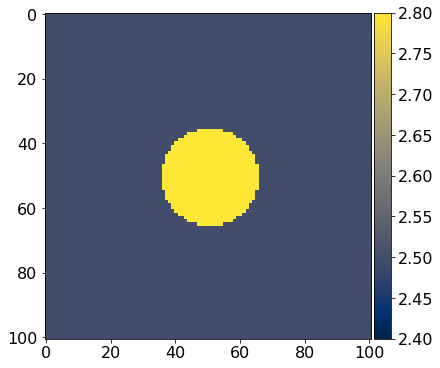

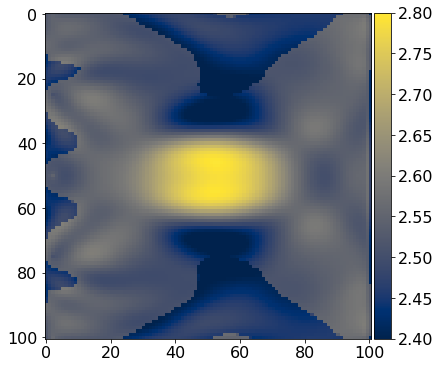

In [8]:
#NBVAL_SKIP

# Plot FWI result
from examples.seismic import plot_image

slices = tuple(slice(param['nbl'],-param['nbl']) for _ in range(2))
vp = 1.0/np.sqrt(result['x'].reshape(true_model.shape))
plot_image(true_model.vp.data[slices], vmin=2.4, vmax=2.8, cmap="cividis")
plot_image(vp, vmin=2.4, vmax=2.8, cmap="cividis")

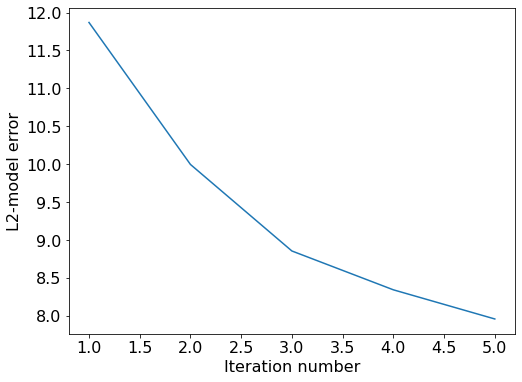

In [9]:
#NBVAL_SKIP
import matplotlib.pyplot as plt

# Plot model error
plt.plot(range(1, maxiter+1), relative_error); plt.xlabel('Iteration number'); plt.ylabel('L2-model error')
plt.show()

As can be observed in last figures, the results we obtain are exactly the same to the ones obtained in [04_dask.ipynb](https://github.com/devitocodes/devito/blob/master/examples/seismic/tutorials/04_dask.ipynb)